<!-- #  Семинар: Рекурентные нейронные сети. -->

В данной работе вам предлагается посмотреть на всю мощь рекурентных нейронных сетей решив небольшую задачу. 

 Предлагаю решить вам задачу расшифровки сообщения с помощью RNN. 
 Представьте, что вам даны сообщения зашифрованные с помощью шифра Цезаря, являющимся одним из самый простых шифров в криптографии.
 

Шифр цезаря работает следующим образом: каждя буква 
исходного алфавита сдвигается на K символов вправо: 

Пусть нам дано сообщение: message="RNN IS NOT AI", тогда наше шифрование выполняющиеся по правилу f, с K=2, даст нам результат:
f(message, K) = TPPAKUAPQVACK

Для удобство можно взять символы только одного регистра в нашей имплементации, и сказать, что все буквы не английского алфавита будут отмечены как прочерк "-".

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Определим ключ и словарь
key = 2
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ012']

In [3]:
# Напишем функцию, которая делает 
def encrypt(text, key):
    """Returns the encrypted form of 'text'."""

    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(key + i) % len(vocab) for i in indexes]   
    encrypted_chars = [vocab[i] for i in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    
    return encrypted

print(encrypt('RNN IS NOT AI', key))

TPPAKUAPQVACK


Теперь нам необходимо нагенерировать датасет для решения задачи обучения с учителем. Нашим датасетом может быть случайно зашифрованные фразы, и тогда его структура будет следующей:
message --- encrypted message

Это пример параллельного корпуса из НЛП.

Но нам необходимо представить каждую букву в виде ее номера в словаре, чтобы далее воспользоваться Embedding слоем. 

Для простоты давайте допустим, что все строки имеют одинаковую длину seq_len

In [4]:
num_examples = 256 # размер датасета
seq_len = 18 # максимальная длина строки


def encrypted_dataset(dataset_len, k):
    """
    Return: List(Tuple(Tensor encrypted, Tensor source))
    """
    dataset = []
    for x in range(dataset_len):
        random_message  = ''.join([random.choice(vocab) for j in range(seq_len)])
        encrypt_random_message = encrypt(''.join(random_message), k)
        src = [vocab.index(ch) for ch in random_message]
        tgt = [vocab.index(ch) for ch in encrypt_random_message]
        dataset.append([torch.tensor(tgt), torch.tensor(src)])
    return dataset

**Pytorch RNN:**
$$h_t = \text{tanh}(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})$$

**where : $h_t$ is the hidden state at time $t$, $x_t$ is
    the input at time $t$, and $h_{(t-1)}$ is the hidden state of the
    previous layer at time $t-1$ or the initial hidden state at time $0$.**
    
Args: 

$input\_size$: The number of expected features in the input $x$ <br>
$hidden\_size$: The number of features in the hidden state $h$ <br>
$num\_layers$: Number of recurrent layers. E.g., setting <br>

![img](https://neuralnet.info/wp-content/uploads/2017/08/3-tanh-activation-function.png)

In [5]:
class Decipher(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 rnn_type='simple'):
        """
        :params: int vocab_size 
        :params: int embedding_dim
        :params
        """
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == 'simple':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers)
         
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(num_layers, 1, hidden_dim)

        
    def forward(self, cipher):
        # CHECK INPUT SIZE
        # Unsqueeze 1 dimension for batches
        embd_x = self.embed(cipher).unsqueeze(1)
        
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)

        #print(out_rnn.shape, hidden.shape)
        # Apply the affine transform and transpose output in appropriate way
        # because you want to get the softmax on vocabulary dimension
        # in order to get probability of every letter
        
        return self.fc(out_rnn).transpose(1, 2)
      

In [6]:
# определим параметры нашей модели
embedding_dim = 5
hidden_dim = 10
num_layers=1
vocab_size = len(vocab) 
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()

# Инициализируйте модель
model = Decipher(vocab_size, embedding_dim, hidden_dim, num_layers)

# Инициализируйте оптимизатор: рекомендуется Adam
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

num_epochs = 7

In [7]:
def count_parameters(model):
    return sum(t.numel() for t in model.parameters() if t.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 666 trainable parameters


In [8]:
# ....

Epoch: 0
Loss: 2.8131


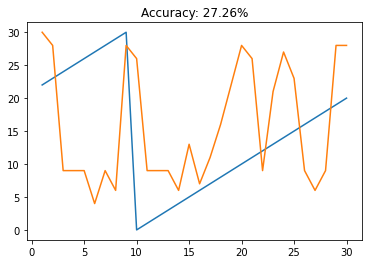

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  HHHJOLYHRTEOYHTTOH0H20
Epoch: 1
Loss: 2.0517


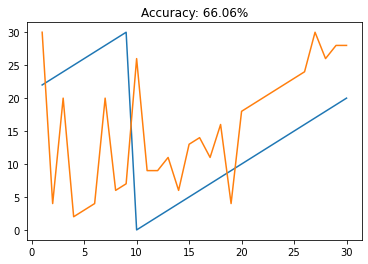

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  BWHJOV HRTEO HTTMJ1J20
Epoch: 2
Loss: 1.5012


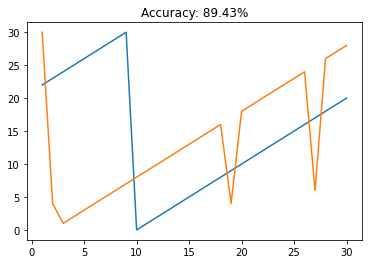

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  BAINOV ARTEMCITTM-1-20
Epoch: 3
Loss: 0.9072


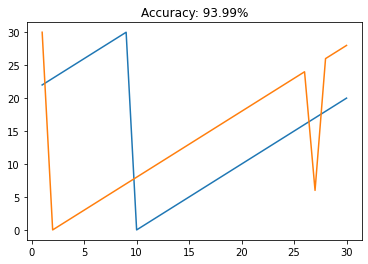

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  BAINOV ARTEM ITTM-1-20
Epoch: 4
Loss: 0.6302


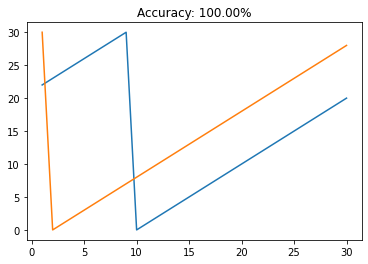

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  BAINOV ARTEM ITTM-1-20
Epoch: 5
Loss: 0.4608


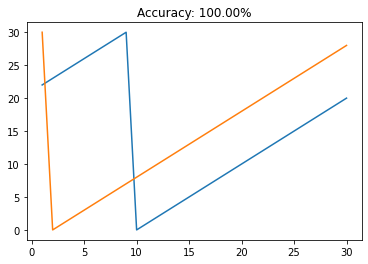

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  BAINOV ARTEM ITTM-1-20
Epoch: 6
Loss: 0.3754


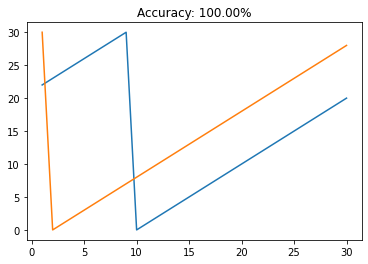

Шифрование фразы BAINOV ARTEM ITTM-1-20  =  DCKPQXACTVGOAKVVOB B-2
Расшифровка фразы  =  BAINOV ARTEM ITTM-1-20


In [9]:
k = 2
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in encrypted_dataset(num_examples, k):
        scores = model(encrypted)
        original = original.unsqueeze(1)
        # Calculate loss
        loss = criterion(scores, original)
        # Zero grads
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))

    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in encrypted_dataset(num_examples, k):
            # Compute a softmax over the outputs
            predictions = F.softmax(model(encrypted), dim=1)
            
            # Choose the character with the maximum probability (greedy decoding)
            j, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total

        import matplotlib.pyplot as plt
        import numpy as np

        plt.title('Accuracy: {:4.2f}%'.format(accuracy * 100))
        plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - 10) % len(vocab))
        with torch.no_grad():
            plt.plot(range(1, len(vocab)), F.softmax(model(torch.tensor(range(1, len(vocab)))), 1).max(dim=1)[1])
        plt.show()
  
    tgt = [vocab.index(ch) for ch in encrypt('BAINOV ARTEM ITTM-1-20', 2)]
    myMessage = ""
    predictions = F.softmax(model(torch.tensor(tgt)), dim=1)
    j, batch_out = predictions.max(dim=1)
    batch_out = batch_out.squeeze(1)
    for index in batch_out:
      for Char in vocab:
        if vocab.index(Char) == index:
          myMessage = myMessage + Char
    print("Шифрование фразы",'BAINOV ARTEM ITTM-1-20'," = ", encrypt('BAINOV ARTEM ITTM-1-20', 2))
    print("Расшифровка фразы"," = ",myMessage)


In [10]:
# ...